In [34]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['image.cmap'] = 'Reds'

import tensorflow as tf
from tensorflow.python import keras
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten, Conv2D, MaxPool2D

from collections import OrderedDict

from sklearn.manifold import TSNE, Isomap
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

from math import ceil

In [2]:
img_rows, img_cols = 28, 28
num_classes = 10

df = pd.read_csv('train.csv')
print('Shape of data file:',df.shape)

X = df.drop('label',axis=1)
X = X/255
X = X.values.reshape(len(X),img_rows,img_cols,1)
print('Shaoe of input data:',X.shape)

labels = df.label.values
y = keras.utils.to_categorical(labels, num_classes)
print('Shape of label vectors:',y.shape)
print('First label vector:',y[0])

del df

Shape of data file: (42000, 785)
Shaoe of input data: (42000, 28, 28, 1)
Shape of label vectors: (42000, 10)
First label vector: [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]


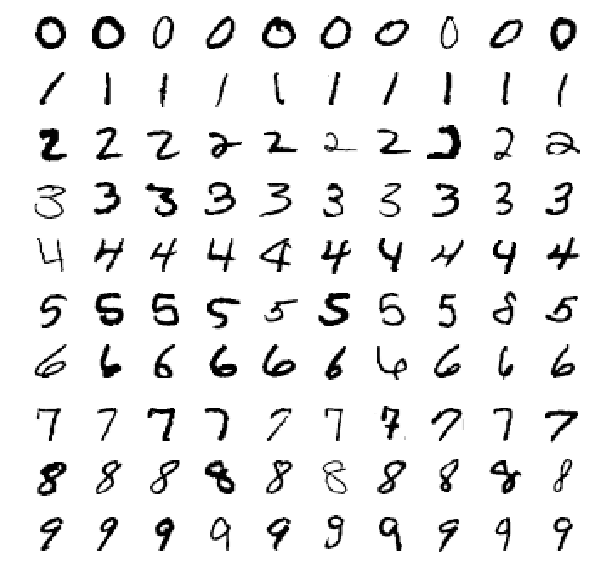

In [3]:
plt.figure(figsize=(10,num_classes))
for i in range(num_classes):
    tmp = X[y[:,i]==1]
    for j in range(10):
        plt.subplot(num_classes,10,(10*i)+(j+1))
        plt.imshow(tmp[j][:,:,0], cmap='Greys')
        plt.clim(0,1)
        plt.axis('off')

In [4]:
# Define model
layers = OrderedDict({
          ######################################################
          # DEFINE NETWORK LAYERS, EXCLUDING OUTPUT LAYER.
          # KEY AND GIVEN NAME ARGUMENT MUST BE THE SAME.
          ######################################################          
          'Conv1': Conv2D(12, kernel_size=(3, 3), 
                          activation='relu',name='Conv1',
                          input_shape=(img_rows, img_cols, 1)),
          'Conv2': Conv2D(12, kernel_size=(3, 3), 
                          activation='relu',name='Conv2'),    
          'Pool1': MaxPool2D(pool_size=(2, 2), strides=2,
                          name='Pool1'),
          'Flatten': Flatten(name='Flatten'),
          'Dense1': Dense(50, activation='relu',name='Dense1'),
          ######################################################
          # PLEASE DO NOT CHANGE OUTPUT LAYER
          'Output': Dense(num_classes, activation='softmax',
                          name='Output')
          ######################################################
        })

n_layers = len(layers)

# Buld model
model = Sequential()

for key,layer in layers.items():
    model.add(layer)

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])

# Fit model
model.fit(X, y,
          batch_size=100,
          epochs=3,
          validation_split = 0.2)


Train on 33600 samples, validate on 8400 samples
Epoch 1/3
33600/33600 [==============================] - 41s 1ms/step - loss: 0.3674 - acc: 0.8917 - val_loss: 0.1323 - val_acc: 0.9588
Epoch 2/3
33600/33600 [==============================] - 40s 1ms/step - loss: 0.1106 - acc: 0.9665 - val_loss: 0.0862 - val_acc: 0.9731
Epoch 3/3
33600/33600 [==============================] - 41s 1ms/step - loss: 0.0748 - acc: 0.9778 - val_loss: 0.0712 - val_acc: 0.9768


In [5]:
layer_out = OrderedDict({})

prev_layer_out = None
max_filters = 9 # initialise to some small non-zero value to deal with case where no convolutional layers

for key in layers.keys():
    layer_model = Sequential()
    layer_model.add(model.get_layer(key))
    
    if prev_layer_out is None:
        layer_out[key] = layer_model.predict(X)
    else:
        layer_out[key] = layer_model.predict(prev_layer_out)
        
    if layer_out[key].ndim==4:
        n_filters = layer_out[key].shape[-1]
        if n_filters>max_filters:
            max_filters = n_filters
            
    prev_layer_out = layer_out[key]
    
    print(key, 'layer has shape',layer_out[key].shape)

Conv1 layer has shape (42000, 26, 26, 12)
Conv2 layer has shape (42000, 24, 24, 12)
Pool1 layer has shape (42000, 12, 12, 12)
Flatten layer has shape (42000, 1728)
Dense1 layer has shape (42000, 50)
Output layer has shape (42000, 10)


In [6]:
def plot_network(img_id):
    
    props = dict(boxstyle='round', facecolor='w')

    nrows = n_layers+1
    txtwidth = max([int(max_filters/12),2])
    ncols = max_filters+txtwidth
    
    fsize = 1.3*ncols#18*(ncols/14)
    
    plt.figure(figsize=(2*ncols,2*nrows))
   
    ####################
    # input
    ####################
    
    # title
    row = 1
    ax = plt.subplot2grid((nrows, ncols), (0, 0), colspan=txtwidth)
    plt.plot([0,0],[1,1])
    ax.text(0, 1, 'Input', verticalalignment='center',fontsize=fsize,bbox=props)
    plt.axis('off')
    
    # show input image
    plt.subplot2grid((nrows, ncols), (0, int((ncols-txtwidth)/2 + 0.5*txtwidth)), colspan=txtwidth)
    plt.imshow(X[img_id][:,:,0])
    plt.clim(0,1)
    plt.axis('off')
    
    # correct label of input image
    ax = plt.subplot2grid((nrows, ncols), (0, txtwidth), colspan=txtwidth)
    plt.plot([0,0],[1,1])
    ax.text(0,1,
            'True label: '+str(y[img_id,:].argmax()),
            verticalalignment='center',horizontalalignment='center',fontsize=fsize,bbox=props)
    plt.axis('off')

    # predicted label for input image
    ax = plt.subplot2grid((nrows, ncols), (0, ncols-txtwidth-1), colspan=txtwidth)
    plt.plot([0,0],[1,1])
    ax.text(0,1,
            'Predicted: '+
            str(layer_out['Output'][img_id,:].argmax())+
            ' ({:.1f}% probability)'.format(100*layer_out['Output'][img_id,:].max()),
            verticalalignment='center',horizontalalignment='center',
            fontsize=fsize,bbox=props)
    plt.axis('off')

    #######################
    # remaining layers
    #######################
    
    for key in layer_out.keys():
        row += 1
        
        # layer title
        #ax = plt.subplot(nrows, ncols, (row-1)*ncols + 1)
        ax = plt.subplot2grid((nrows, ncols), (row-1, 0), colspan=txtwidth)
        plt.plot([0,0],[1,1])
        ax.text(0, 1, key, verticalalignment='center',fontsize=fsize,bbox=props)
        plt.axis('off')
        
        # bar plot for output layer
        if key is 'Output':
            plt.subplot2grid((nrows, ncols), (row-1, txtwidth+1), colspan=ncols-txtwidth-1)
            plt.bar(range(num_classes),layer_out[key][img_id,:],width=1,color='r')
            plt.ylim(0,1)
            plt.xticks(range(10))
            plt.xlim(-0.5,num_classes-0.5)
        
        # plot images for layers with 4 dimensions (image, row, column, filter)
        elif layer_out[key].ndim==4:
            n_filters = layer_out[key].shape[-1]
            nsub_per_filt = max_filters/n_filters
            for i in range(n_filters):
                plt.subplot2grid((nrows, ncols), (row-1, txtwidth+int(i*nsub_per_filt)), colspan=int(nsub_per_filt))
                plt.imshow(layer_out[key][img_id,:,:,i])
                plt.axis('off')
                
        # 1d image plot for flattened layers (e.g. dense)
        else:
            n_filters = layer_out[key].shape[-1]
            
            plt.subplot2grid((nrows, ncols), (row-1, txtwidth), colspan=ncols-txtwidth)
            plt.imshow(layer_out[key][img_id,:].reshape(1,n_filters),aspect=max([n_filters/20,1]))
            plt.axis('off')

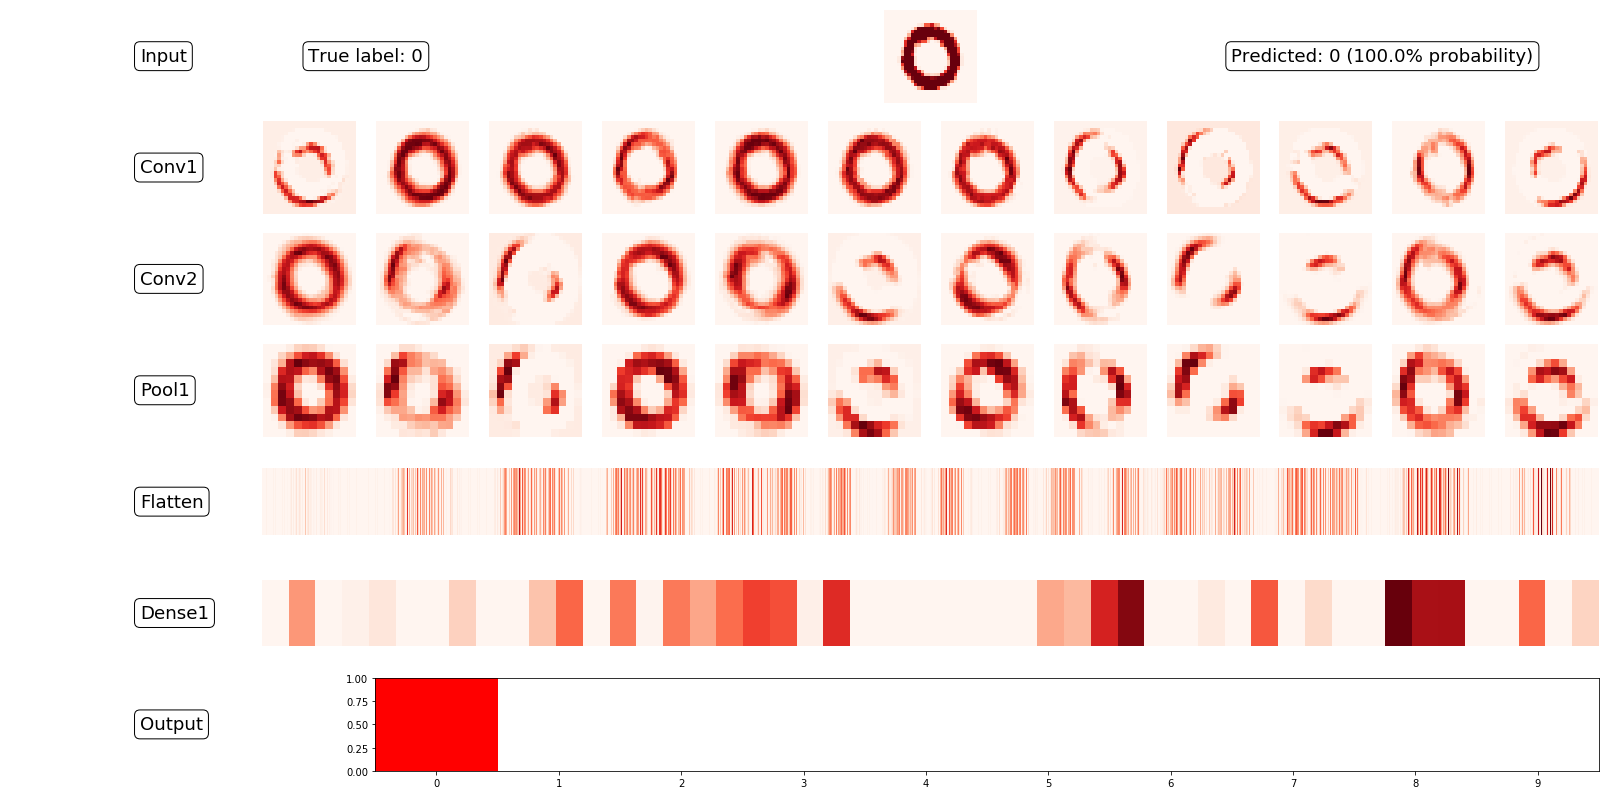

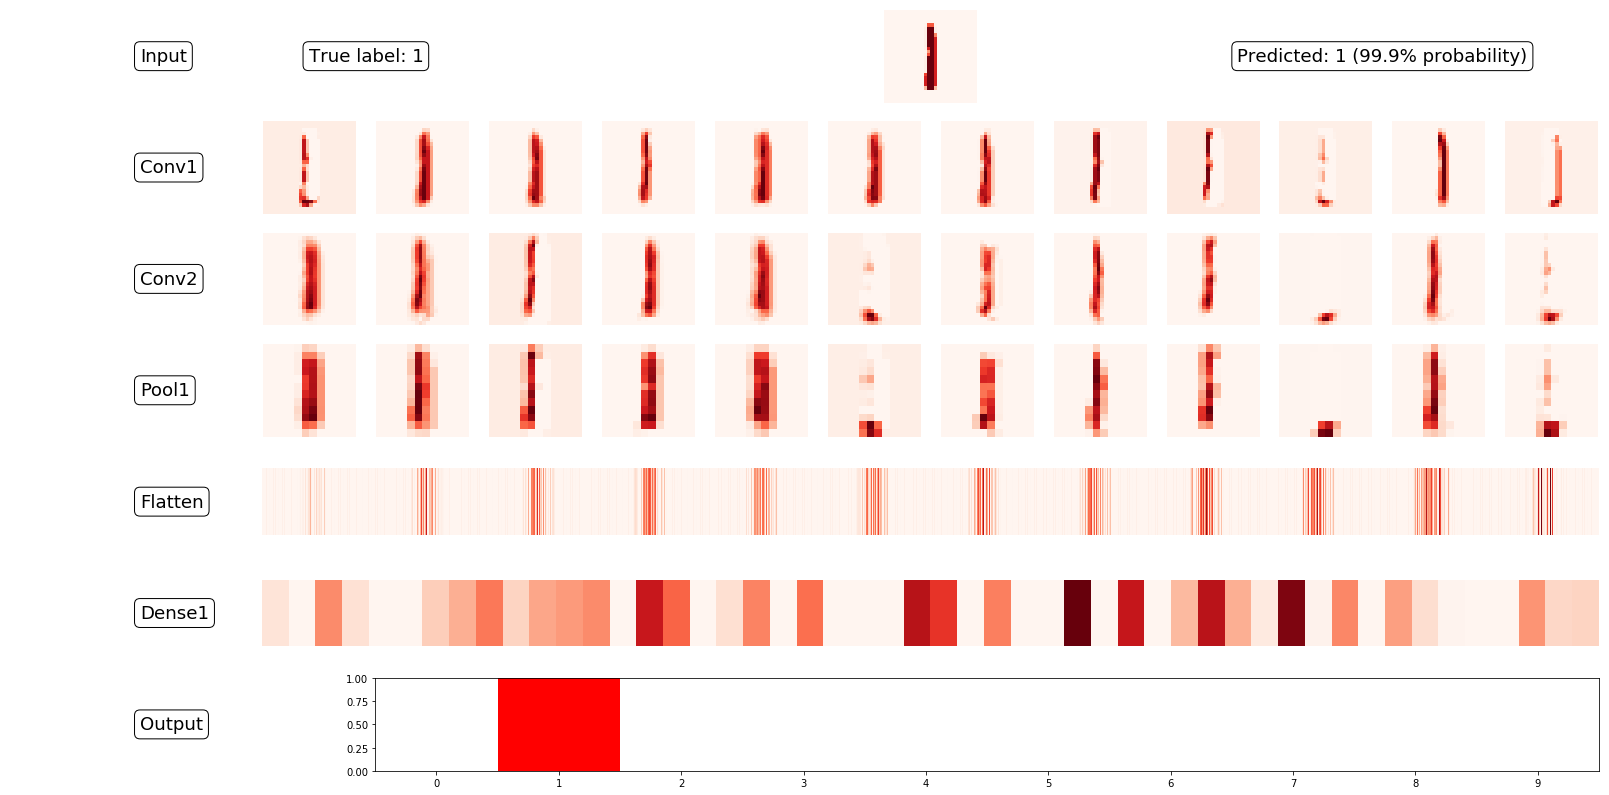

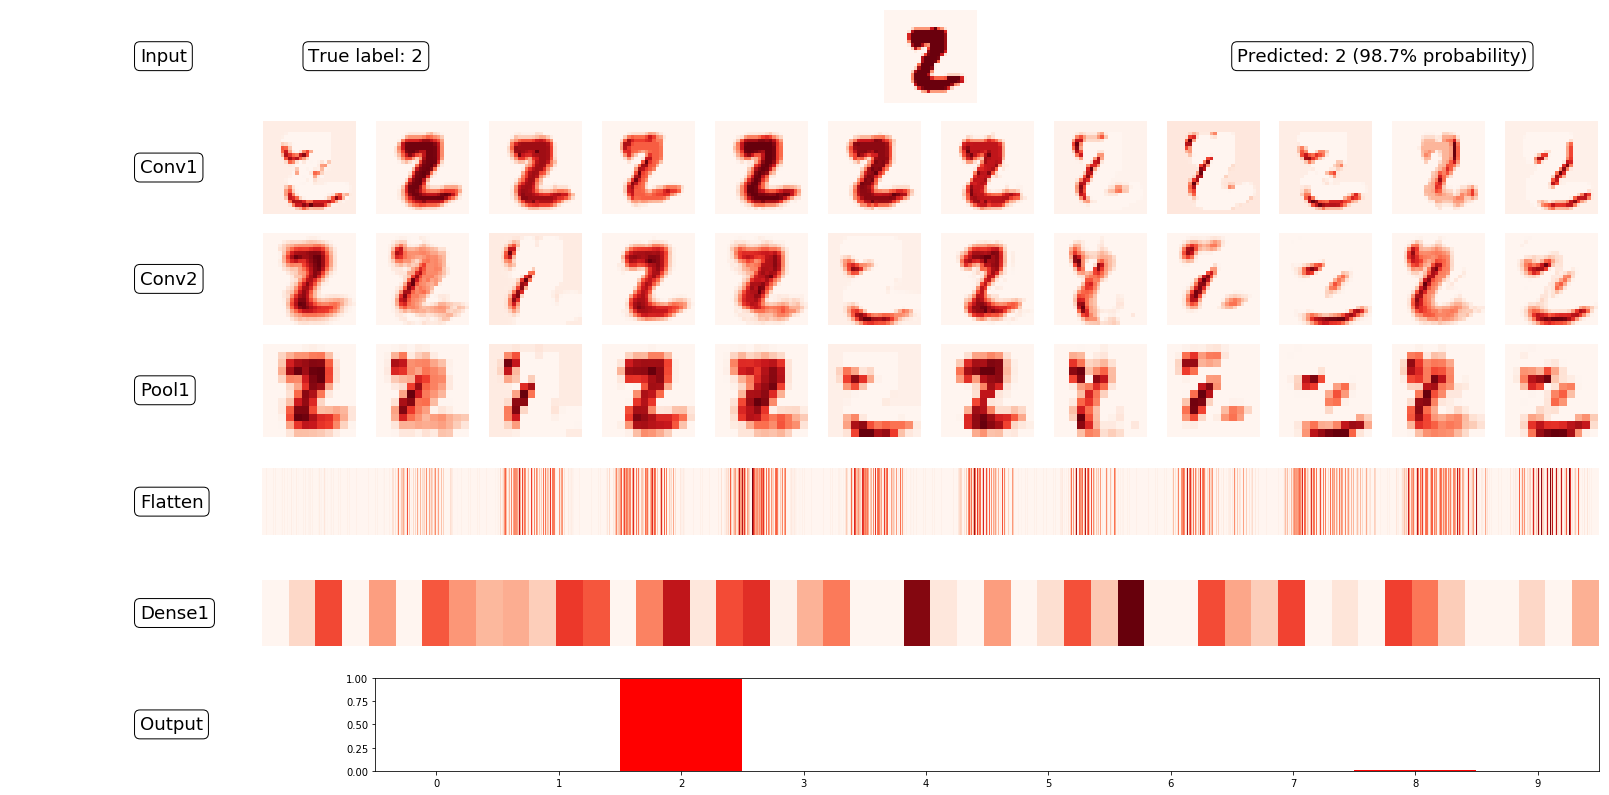

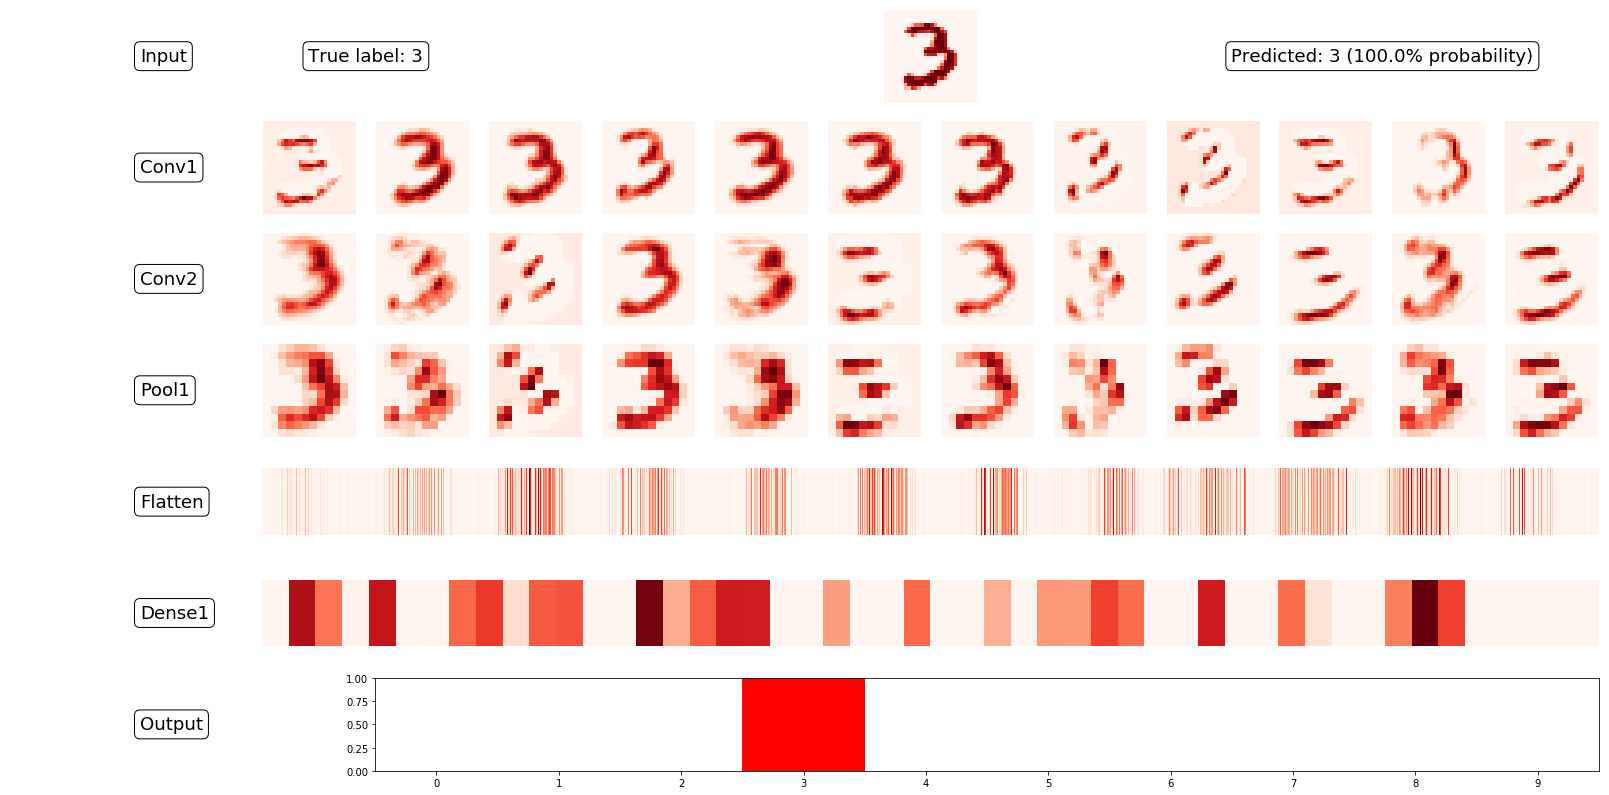

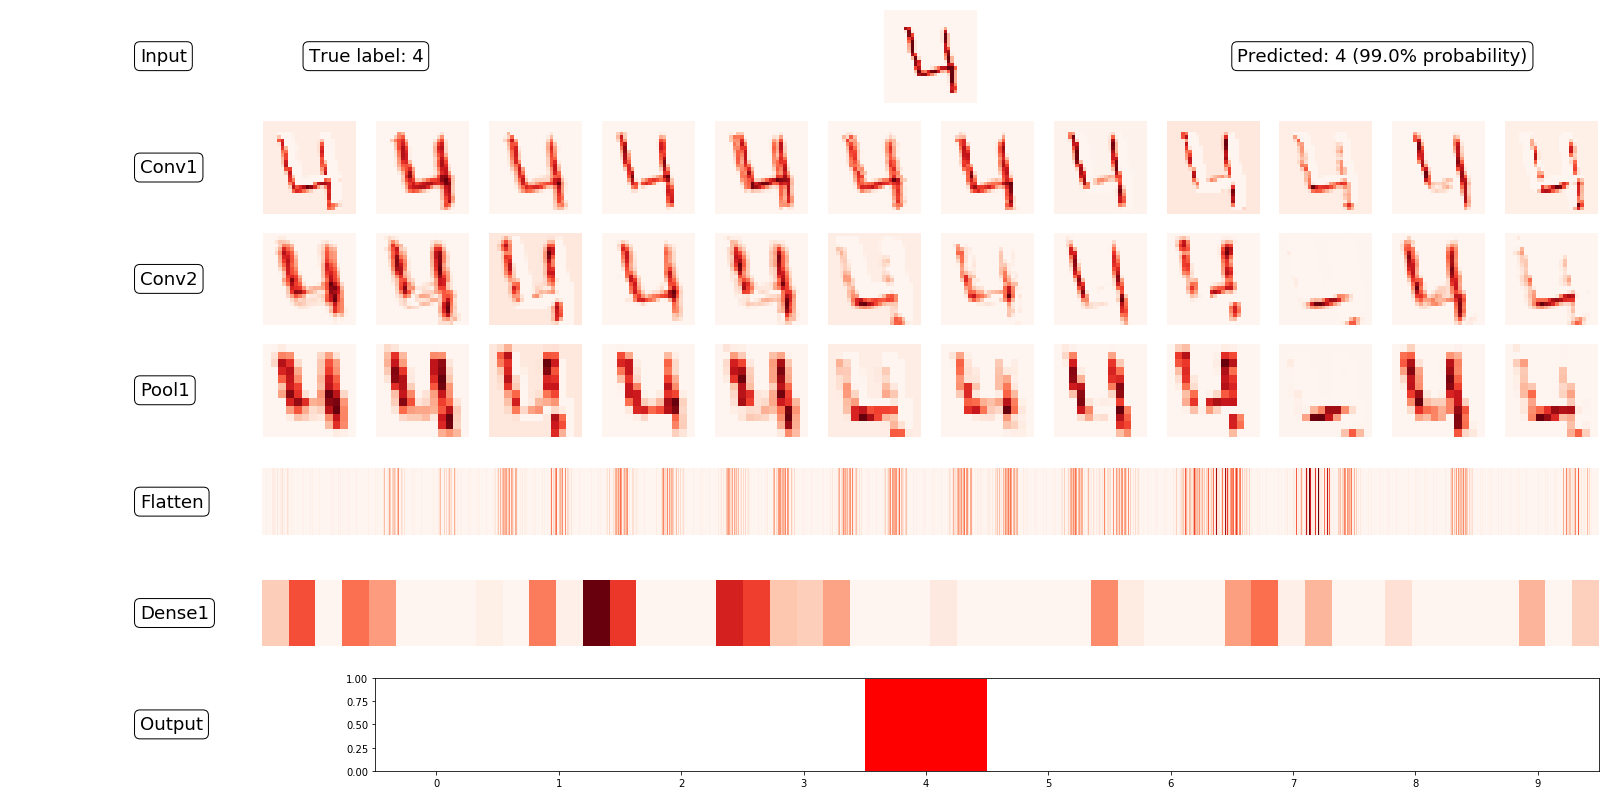

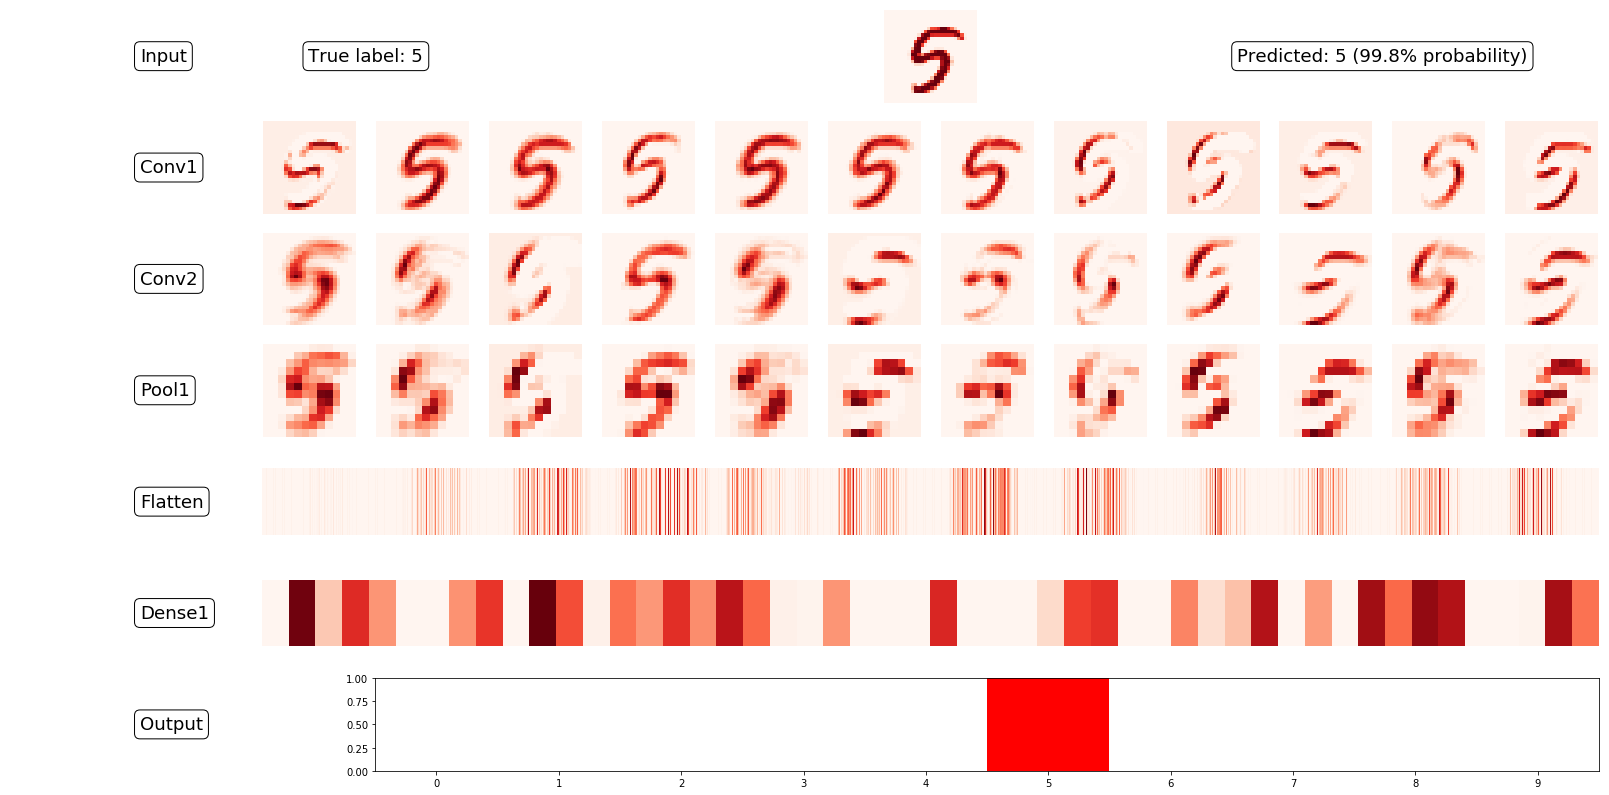

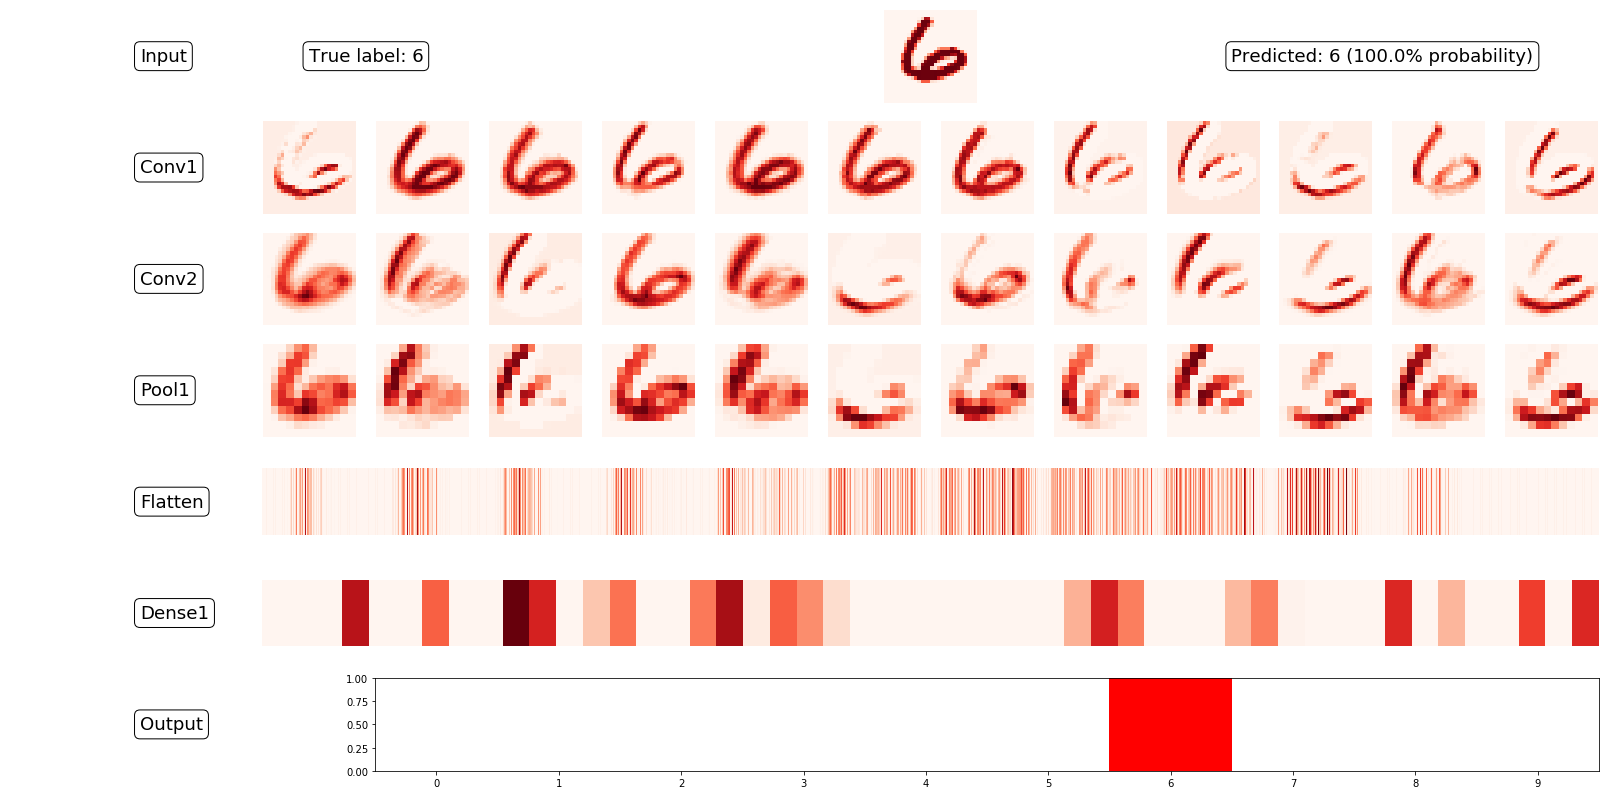

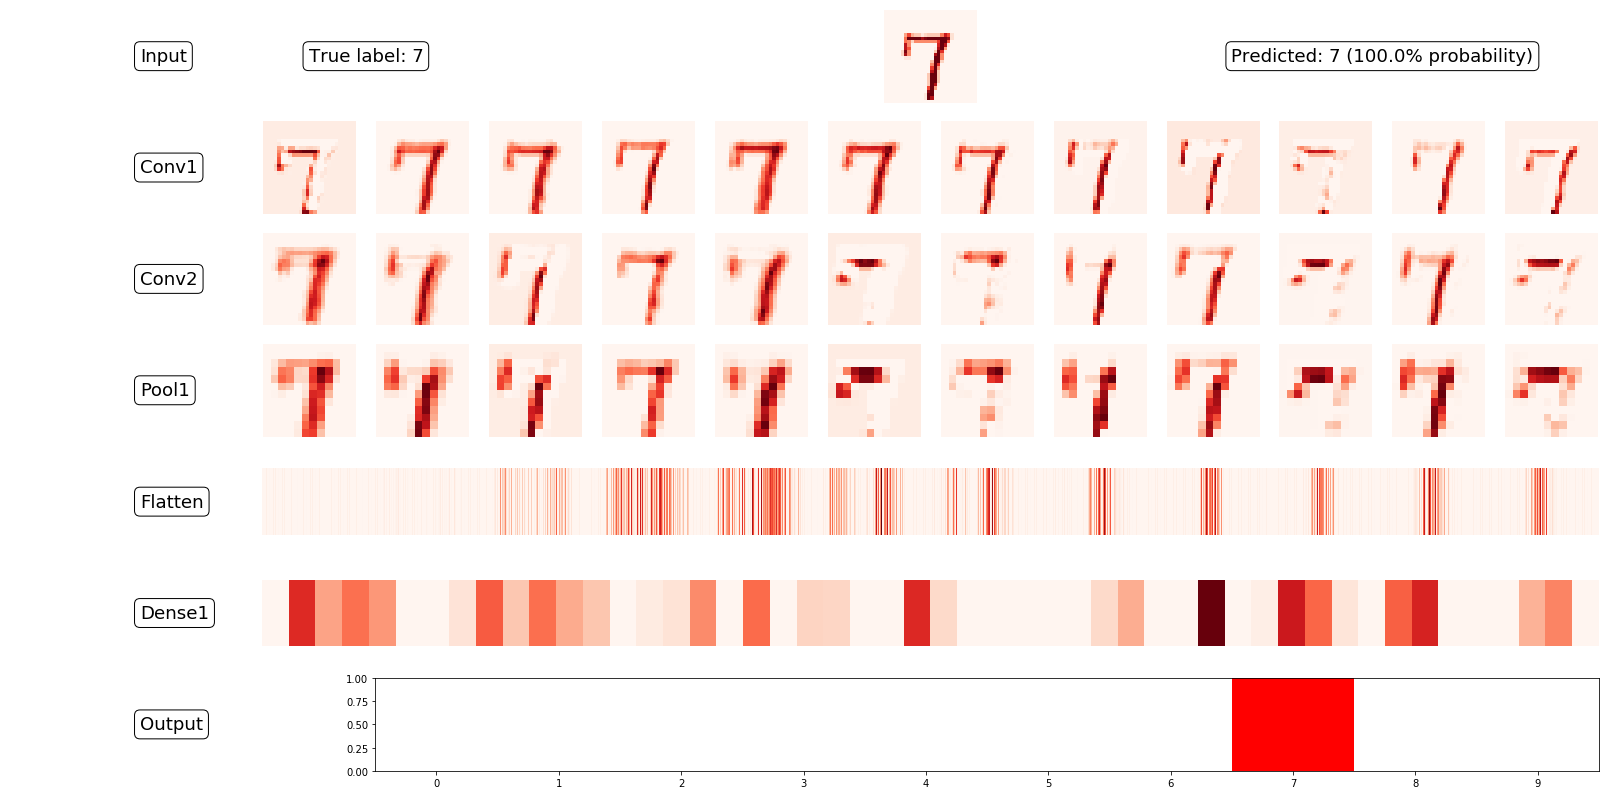

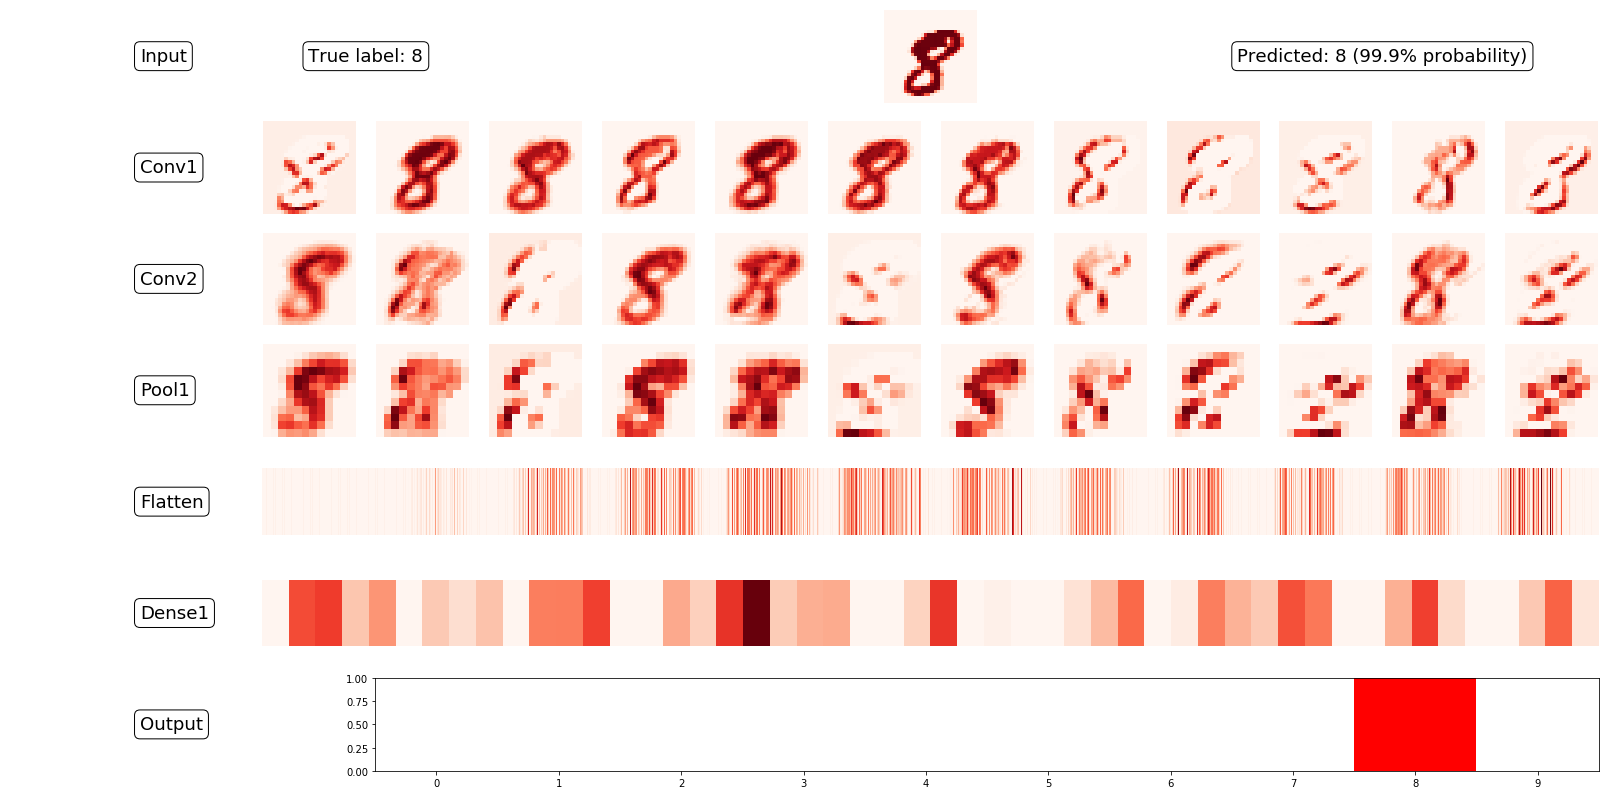

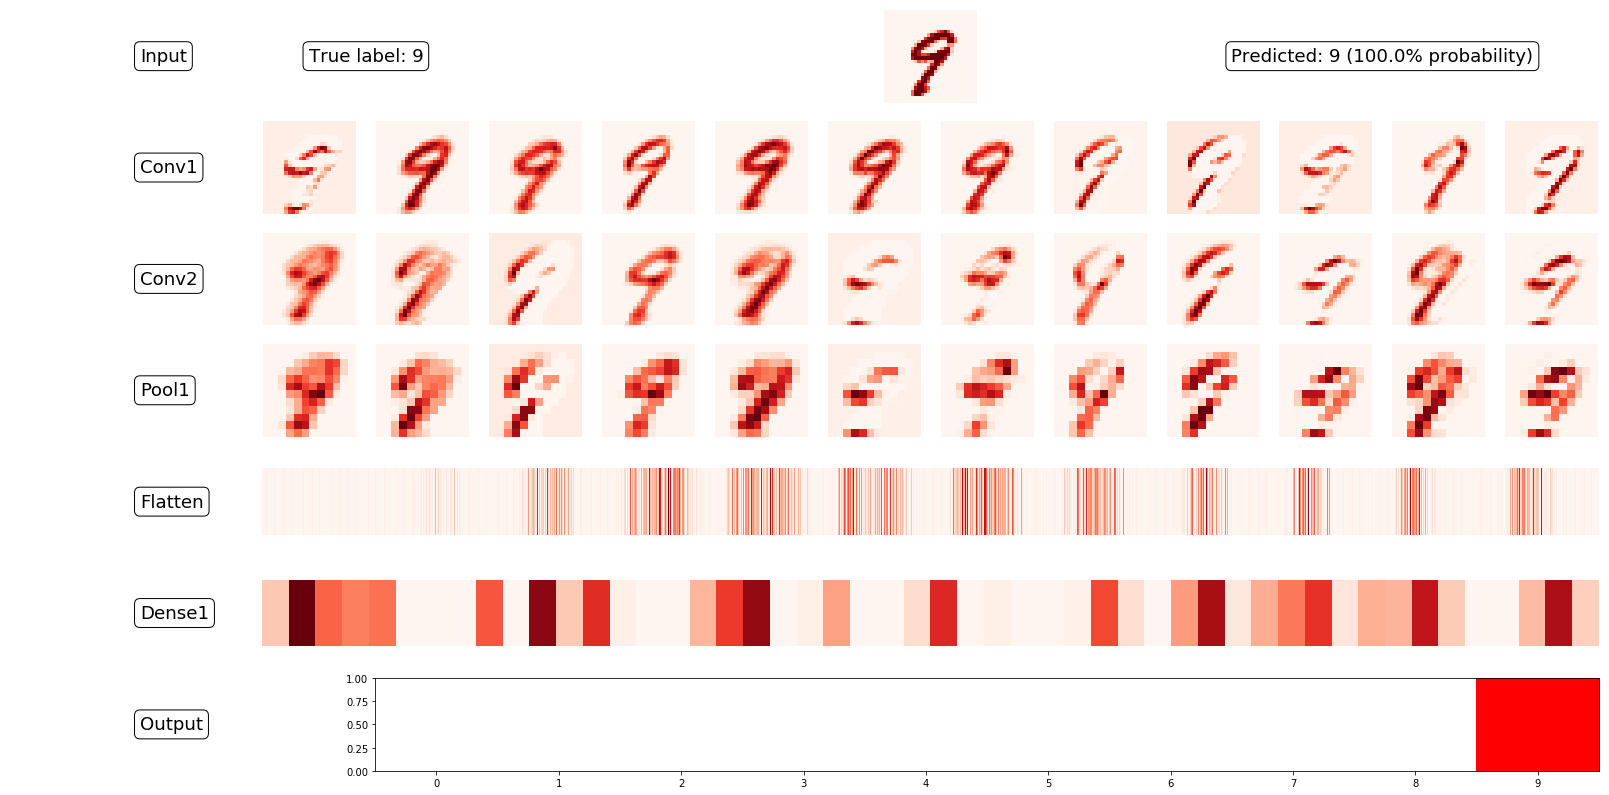

In [7]:
plot_imgs = [1,2,16,9,3,8,72,6,10,11]

for img_id in plot_imgs:
    plot_network(img_id)

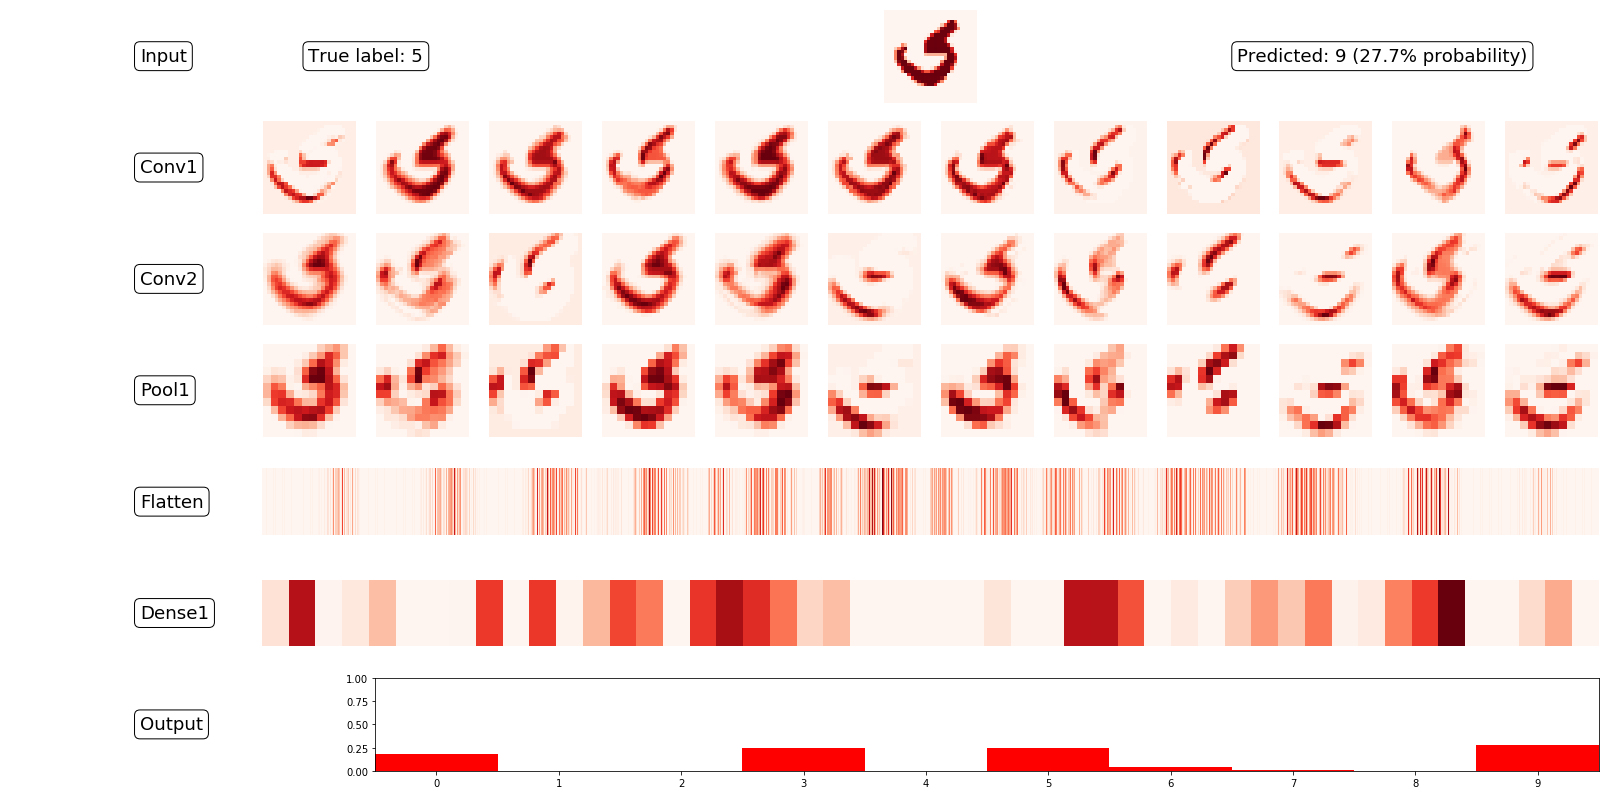

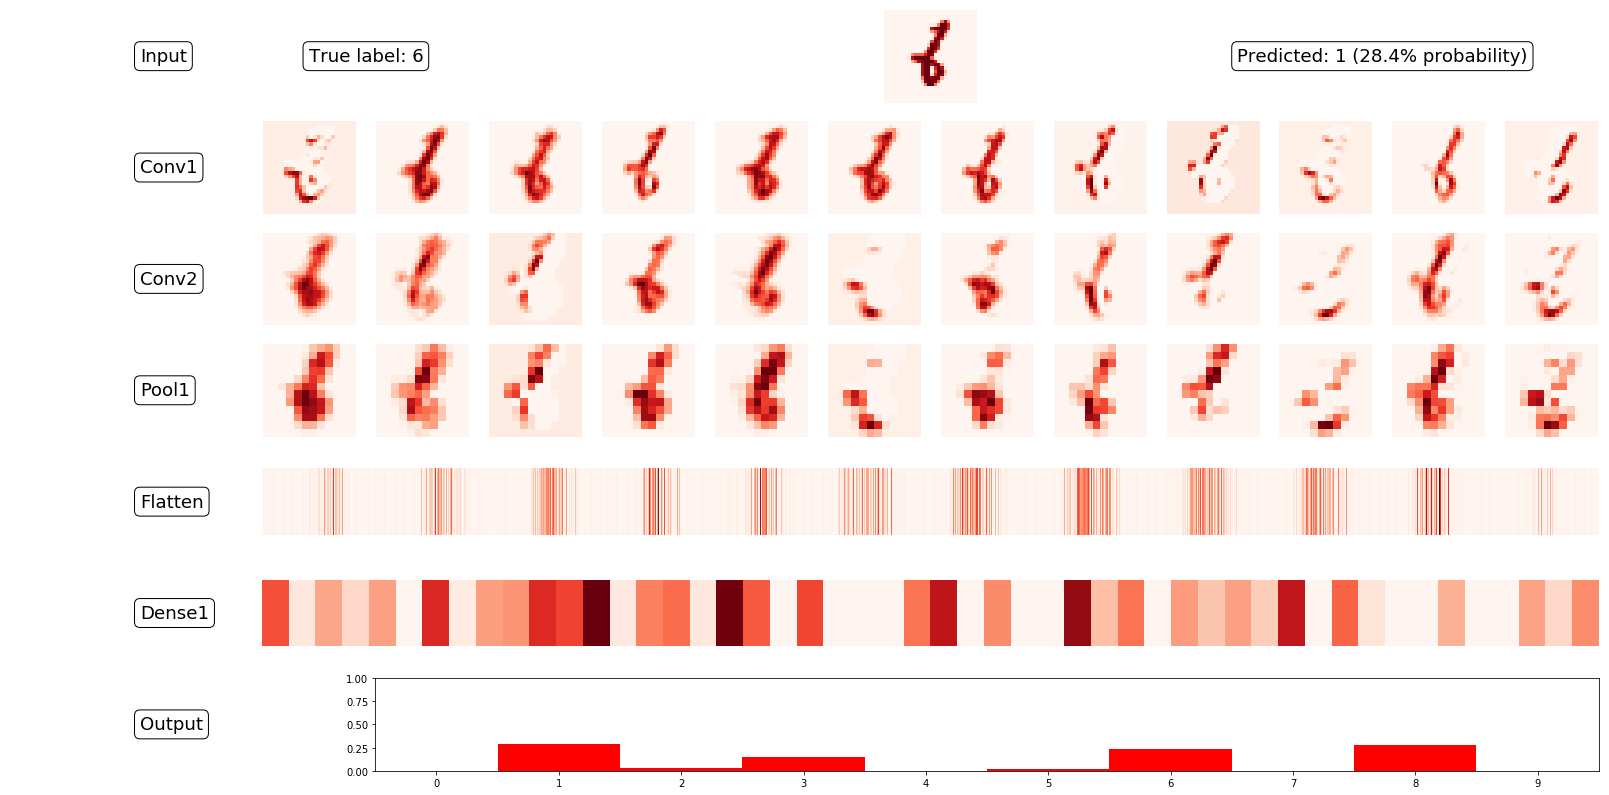

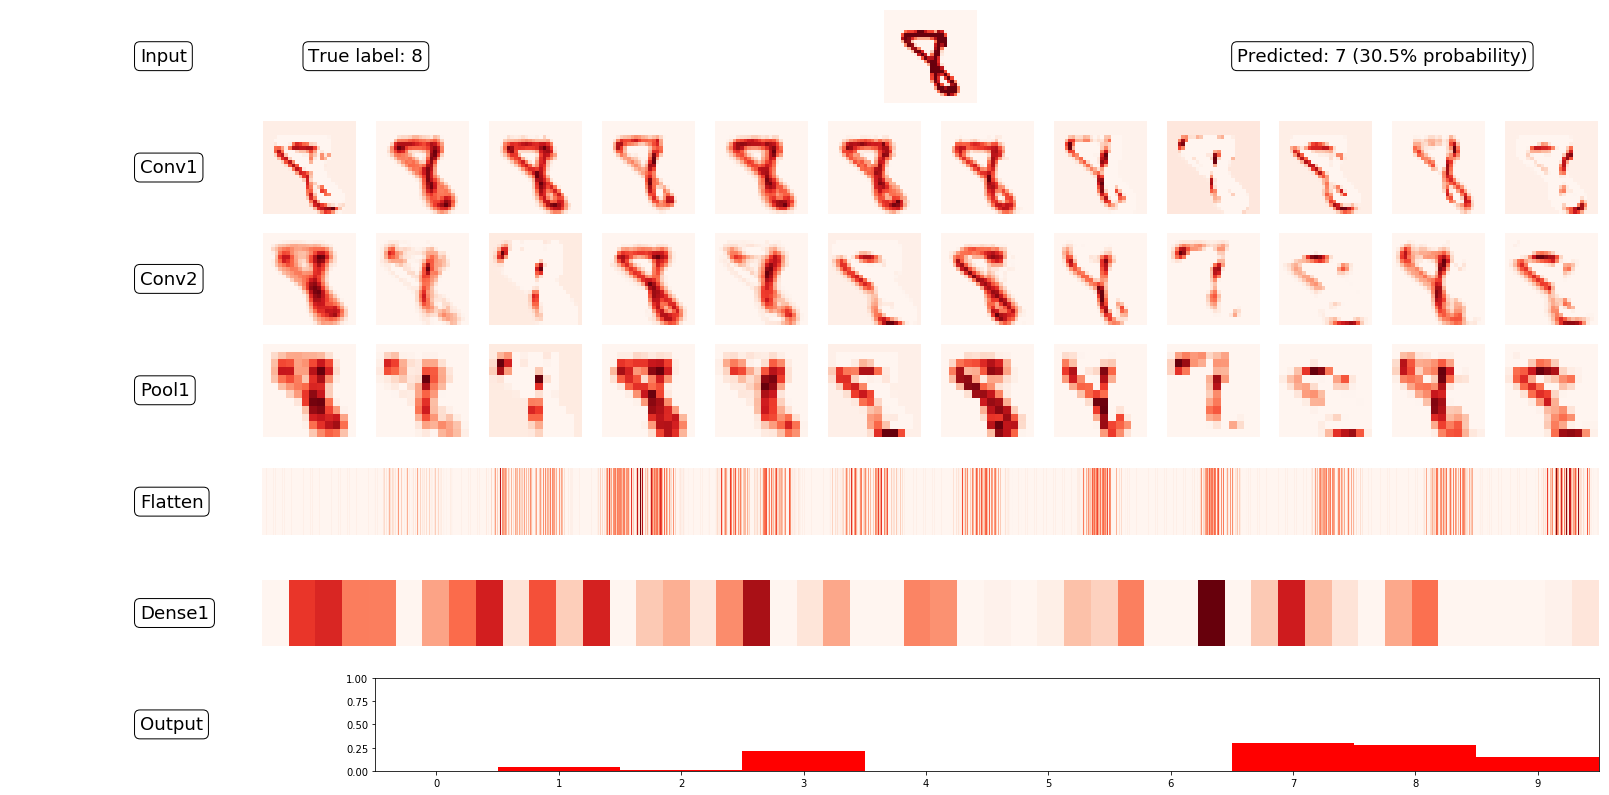

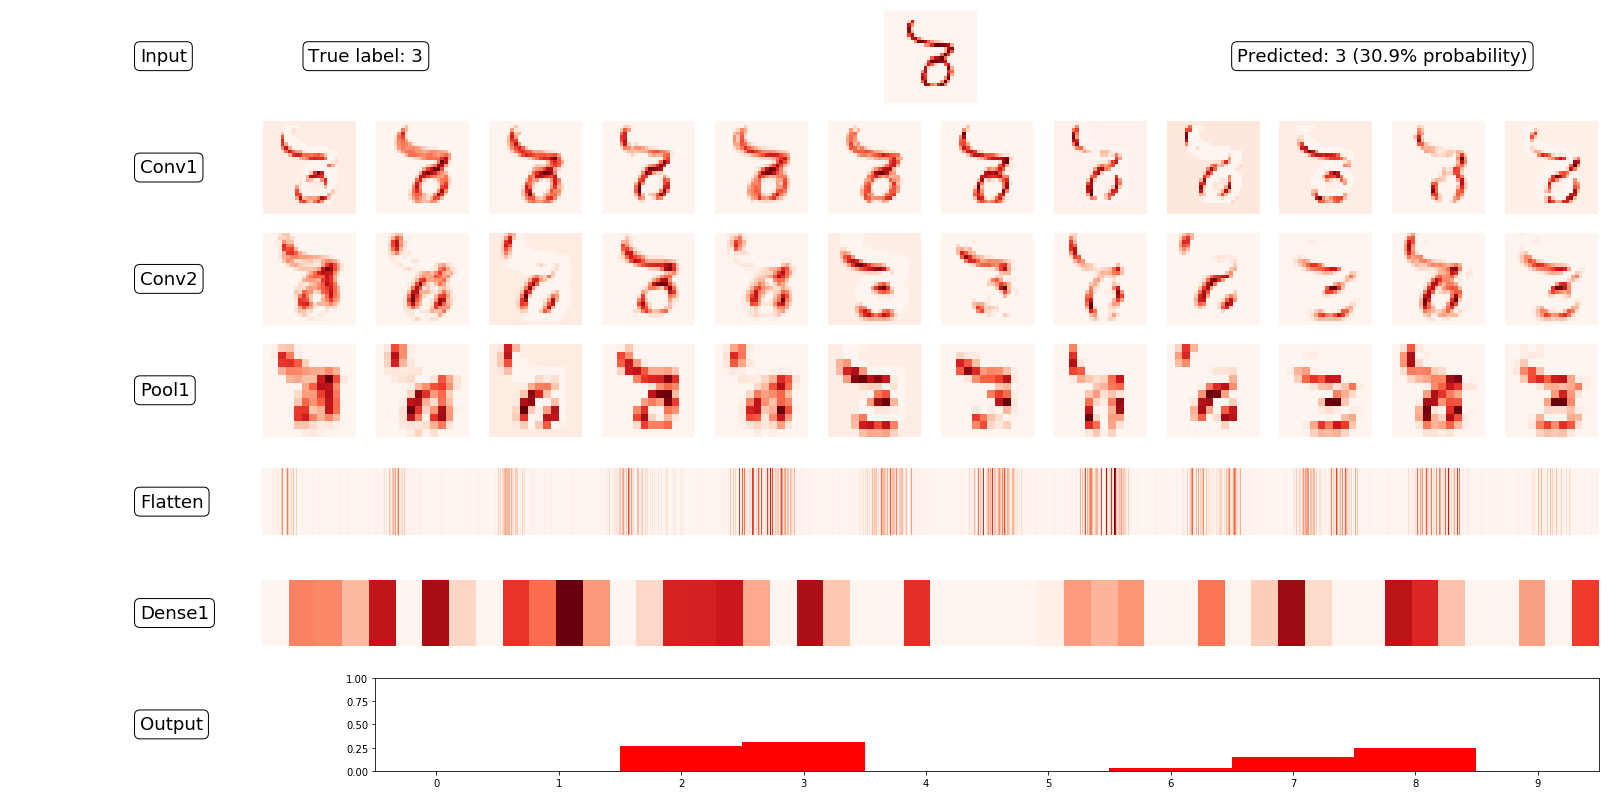

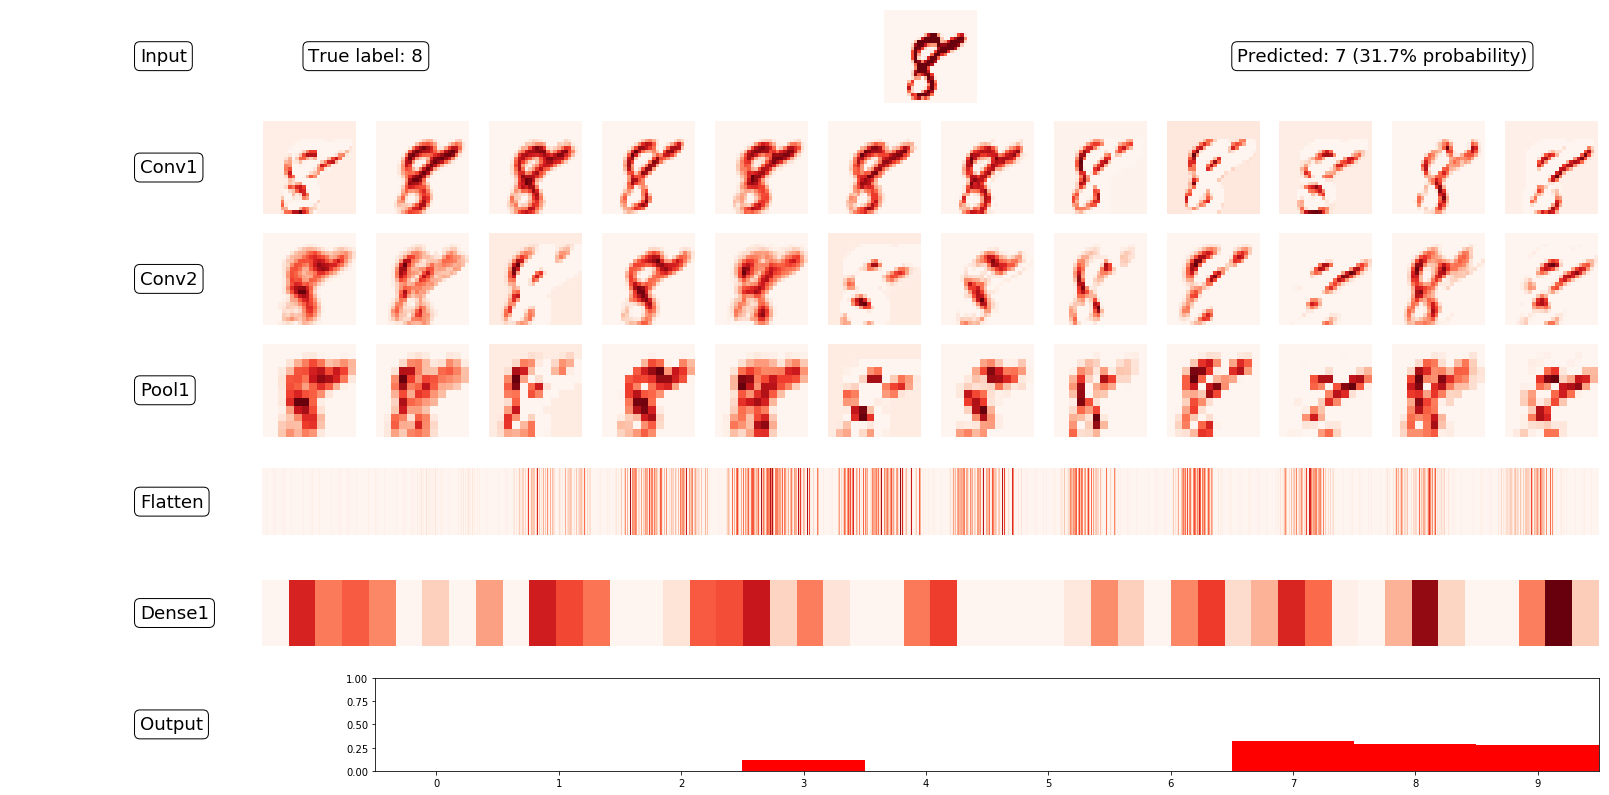

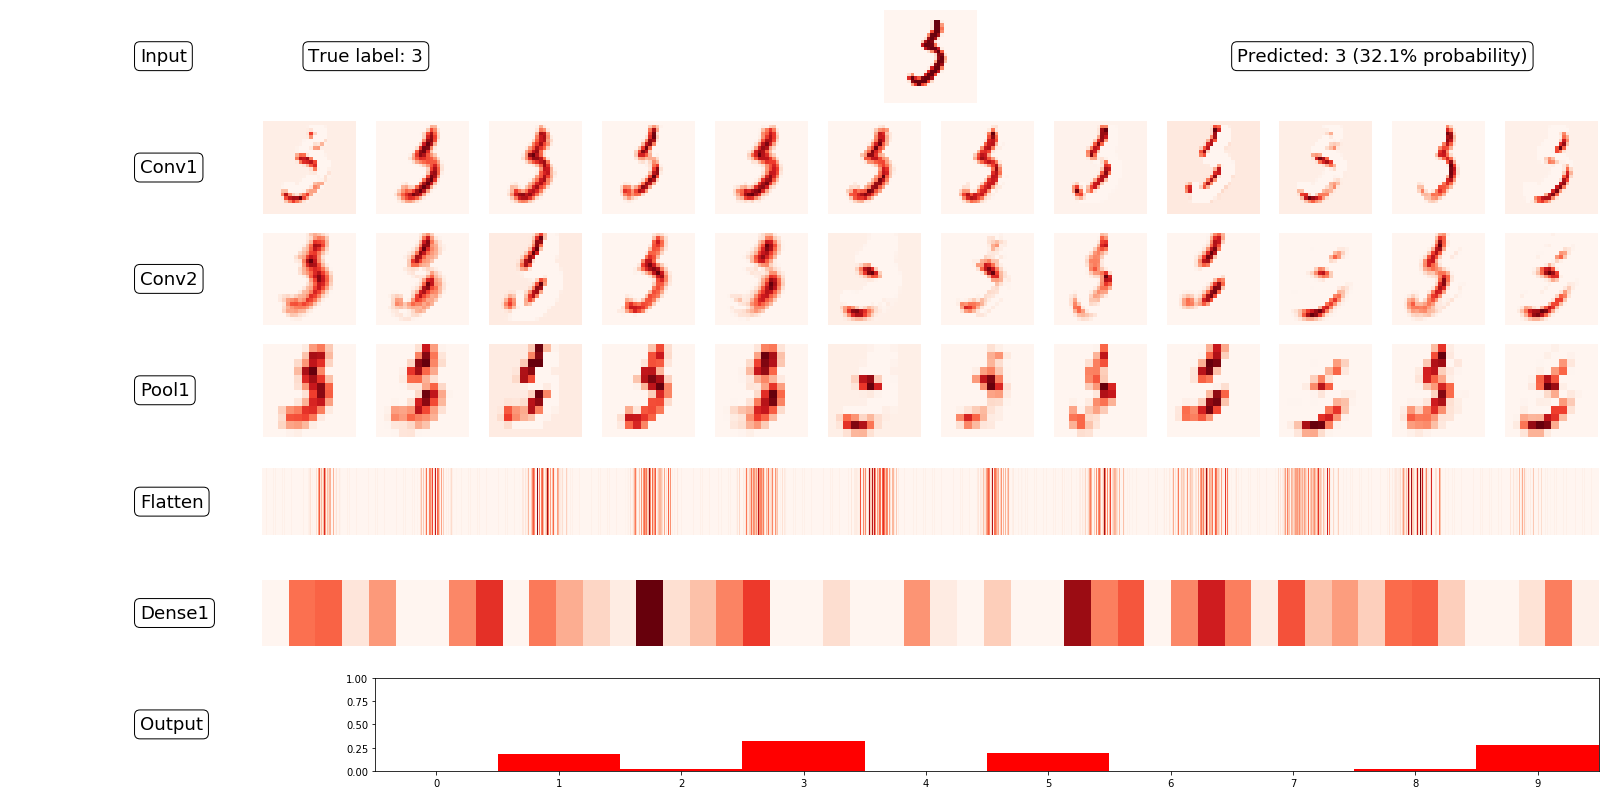

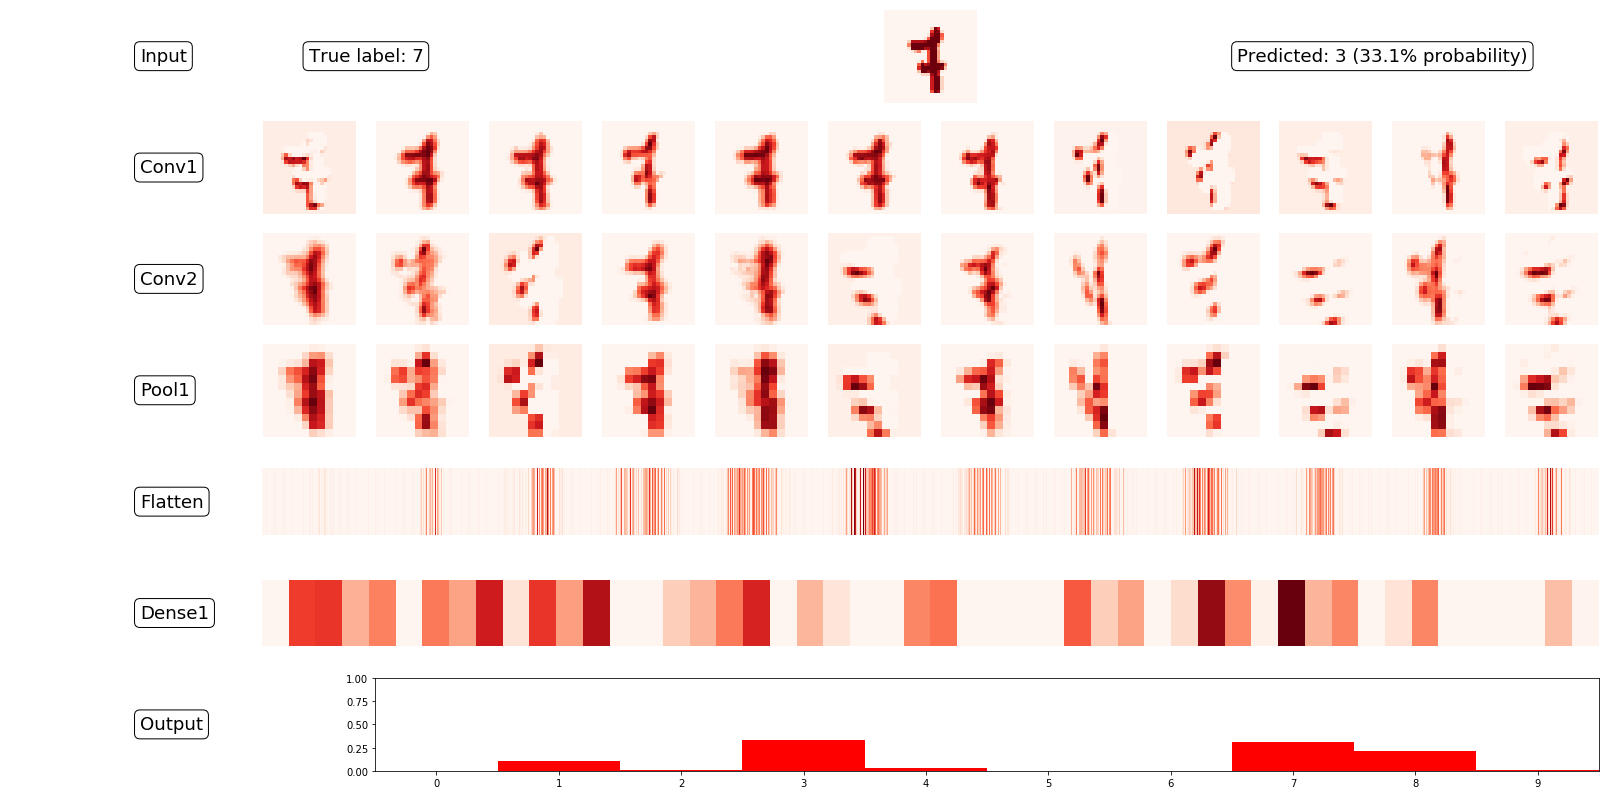

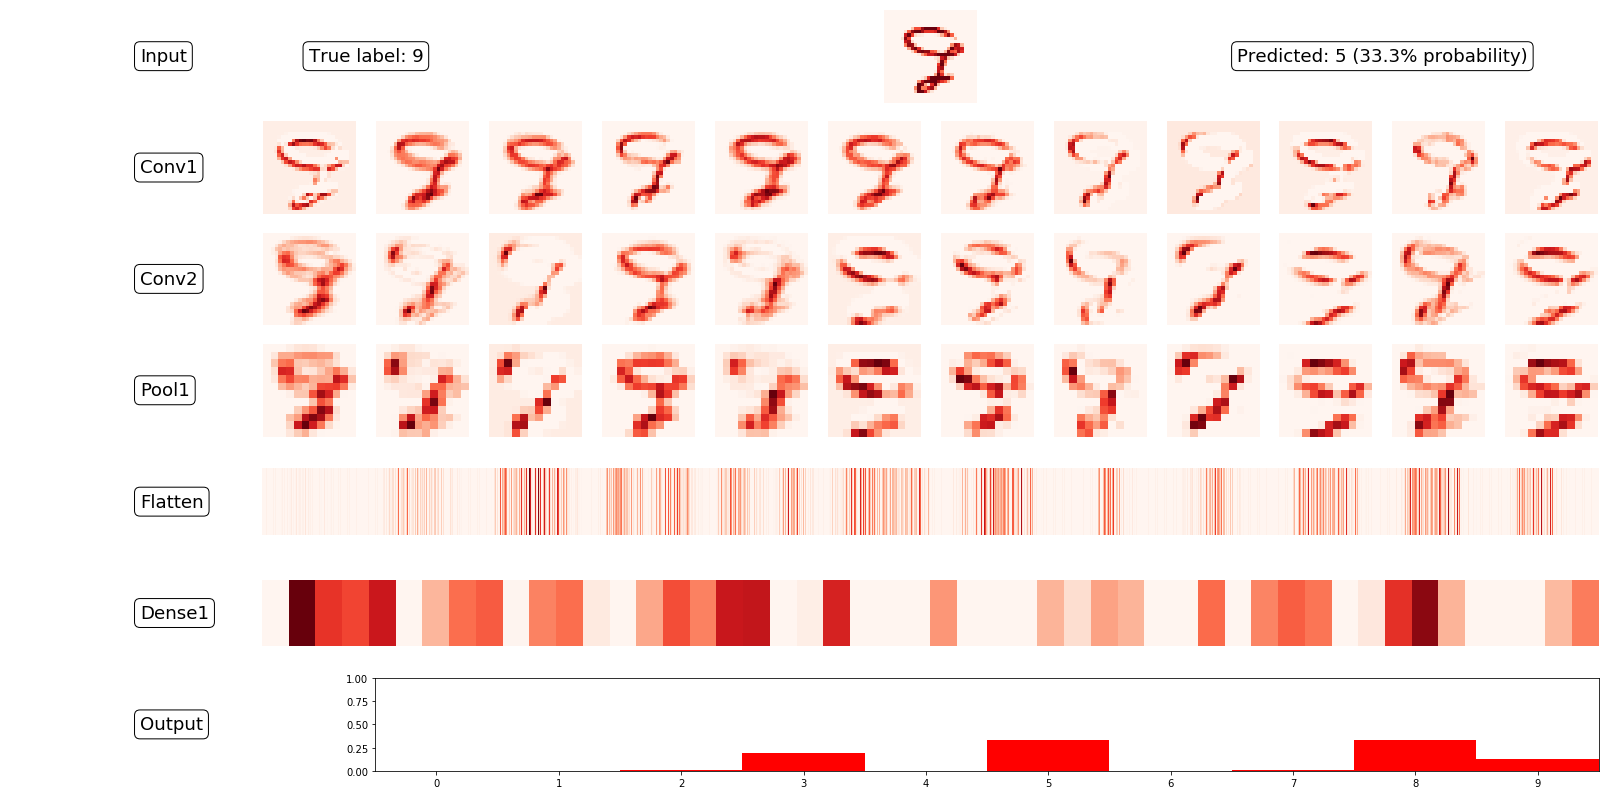

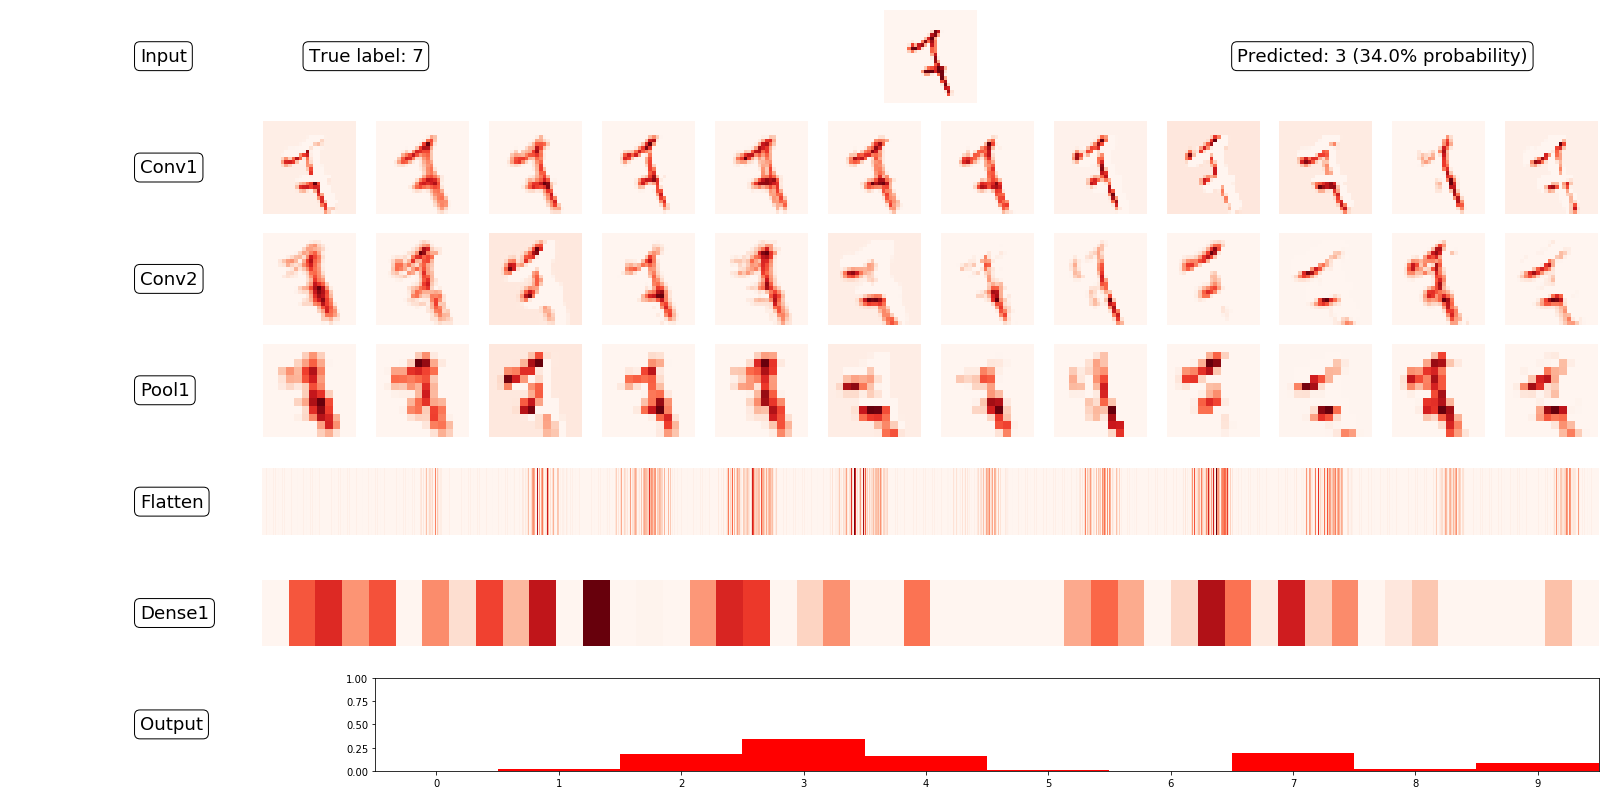

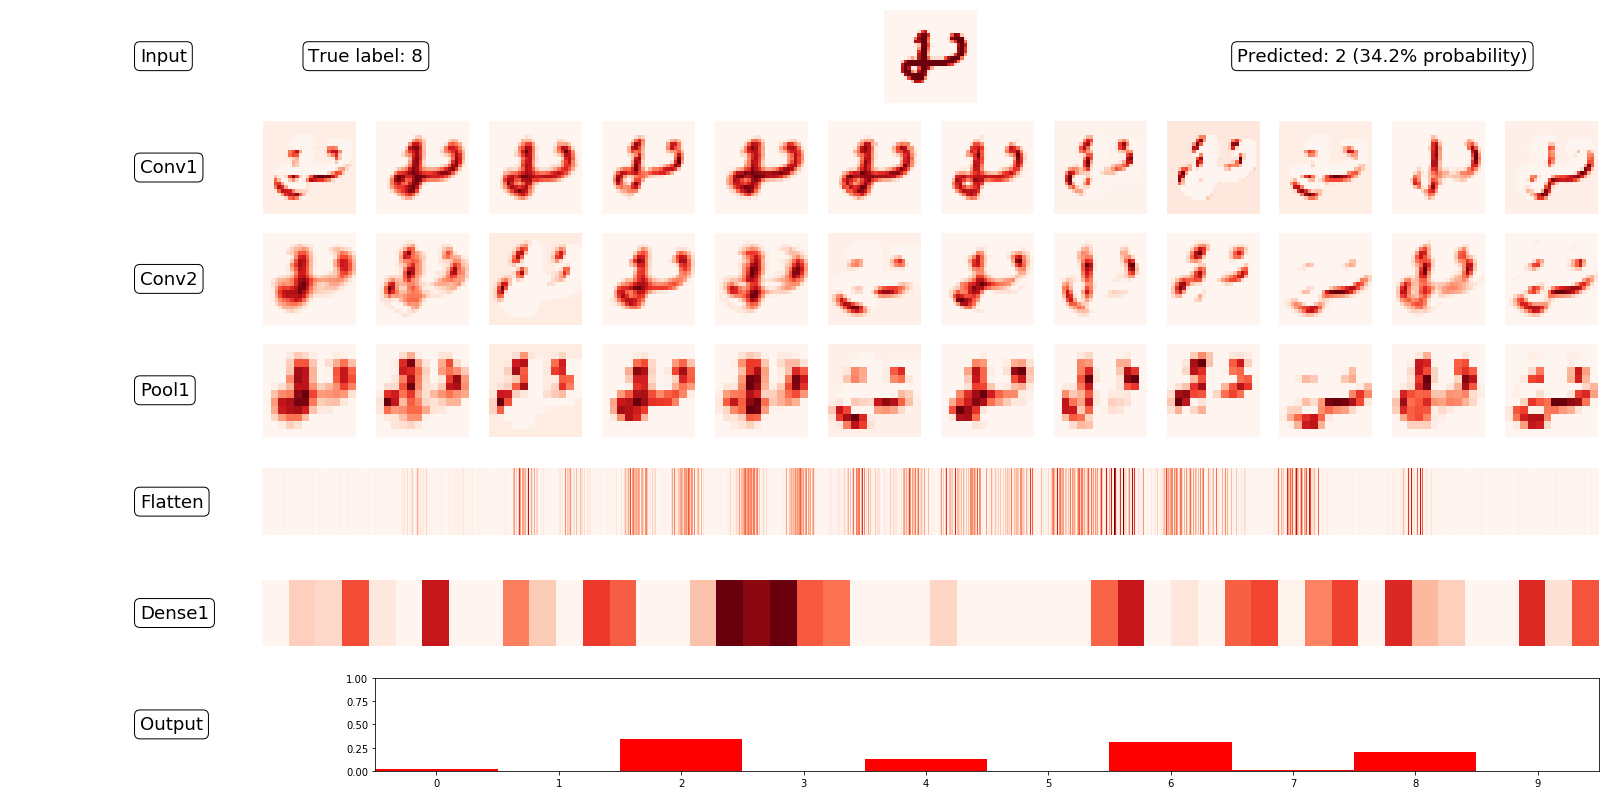

In [8]:
worst_pred = layer_out['Output'].max(axis=1).argsort()[:10]

for img_id in worst_pred:
    plot_network(img_id)

Input...Conv1...Conv2...Pool1...Flatten...Dense1...Output...Done!


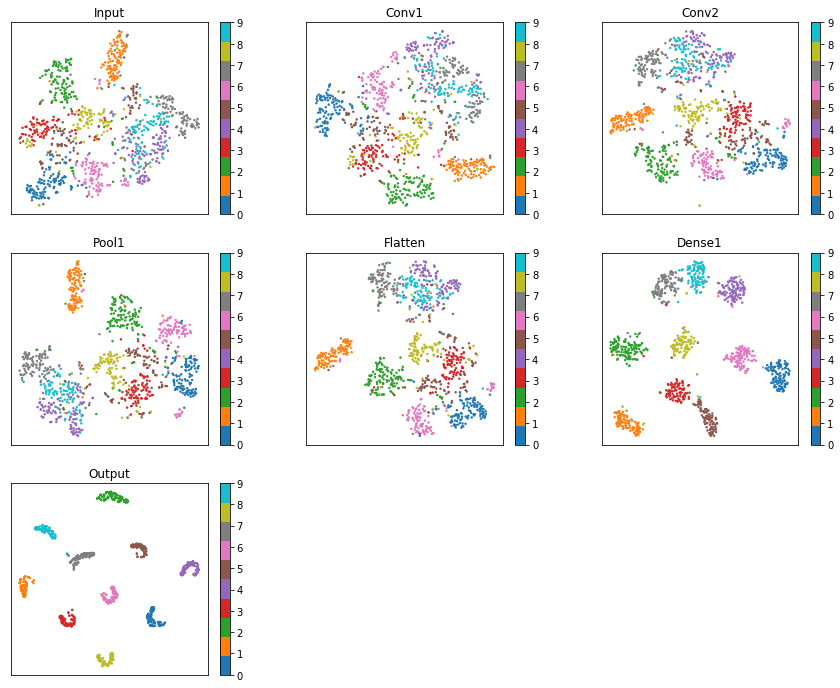

In [41]:
# t-sne or similar to see distinction between digits at different layers?
def tsne_layers(img_ids):
    pipe = Pipeline([('pca',PCA(n_components=num_classes)),('tsne',TSNE())])

    rows = ceil(np.sqrt(n_layers+1))
    cols = ceil((n_layers+1)/rows)

    plt.figure(figsize=(5*cols,4*rows))
    i=1

    print('Input...',end='')
    pipe_in = X[img_ids].reshape([len(img_ids),-1])
    pipe_out = pipe.fit_transform(pipe_in)

    plt.subplot(rows,cols,i)
    plt.scatter(pipe_out[:,0],pipe_out[:,1],c=labels[img_ids],cmap='tab10',s=2)
    plt.xticks([]), plt.yticks([])
    plt.colorbar()
    plt.title('Input')
    i+=1

    for key,out in layer_out.items():
        print(key+'...',end='')
        pipe_in = out[img_ids].reshape([len(img_ids),-1])
        pipe_out = pipe.fit_transform(pipe_in)

        plt.subplot(rows,cols,i)
        plt.scatter(pipe_out[:,0],pipe_out[:,1],c=labels[img_ids],cmap='tab10',s=2)
        plt.xticks([]), plt.yticks([])
        plt.colorbar()
        plt.title(key)
        i+=1
    print('Done!')
    
img_ids = range(1000)
tsne_layers(img_ids)